## Clasificador
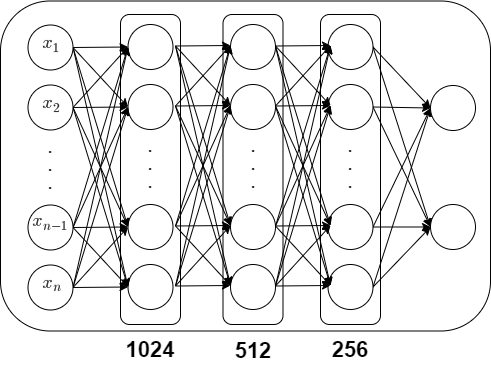

In [38]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import utils
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras import models
from tensorflow.keras import regularizers

from tensorflow_addons.metrics import RSquare

In [7]:
# Una forma de cargar el dataset
%%capture
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IDPzkXd8OVEPAZmujhgR1rXs_dXHOFJj' -O- | sed -rn 's/.confirm=([0-9A-Za-z_]+)./\1\n/p')&id=1IDPzkXd8OVEPAZmujhgR1rXs_dXHOFJj" -O data.csv && rm -rf /tmp/cookies.txt

In [8]:
#Para leer los datos
df = pd.read_csv('data.csv',header=None)

#Separación por escenarios

df_B2B = df.iloc[0:987,:] #Back to back

df_fiber_0 = df.iloc[988:1520,:] #Con fibra a 0dBm

df_fiber_9 = df.iloc[1521:,:] #Con fibra a 9dBm

In [9]:
data = df_B2B # se coloca el dataset de interés
variables = 17 # número de características

# Cambiando las etiquetas
# ¿Por qué se cambia el dato por un valor binario? 
# Para clasificar en dos grupos (Con ruido y sin ruido)
for fil in range (data.shape[0]):
  if(data[19][fil] >= 35.2):
    data[19][fil] = 1
  else:
    data[19][fil] = 0

# Separando variables
X = data.iloc[:,0:variables].values # Variables
y = data.iloc[:,19:20].values # Etiquetas
list_X = list(range(variables))

# Se toma el 30% de los datos para prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=26) 

#Estandarización de las variables de entrada
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


## Modelo optimizado base
- 4 capas
 - 512 (relu), 256 (tanh), 128 (sigmoid), 2 neuronas (softmax)
- Paciencia: 300
- Batch size: 64
- Epochs: 5000

In [ ]:
from time import time
t0 = time()

# Modelo con paradas por error
# monitor = 'loss' y mode = 'min' para minimizar la pérdida
callback = EarlyStopping(monitor='loss', patience=300, mode='min', restore_best_weights=True)
# El modelo secuencial del TensorFlow
model = Sequential()
model.add(Dense(units=512, input_dim=len(list_X), activation='relu'))
model.add(Dense(units=256, activation='tanh'))
model.add(Dense(units=128, activation='sigmoid'))
# Se utiliza Softmax en la última capa para clasificadores
model.add(Dense(2, activation='softmax')) # 2 clases
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')
history_2=model.fit (X_train, y_train, epochs=5000, batch_size=64, callbacks=[callback], verbose=0)
print(len(history_2.history['loss']))
Train_predictions_2_1=model.predict(X_train)
Train_predictions_2_1 = np.argmax(Train_predictions_2_1, axis=-1).astype('int')
acc = accuracy_score(y_train, Train_predictions_2_1)

print(f'El error de esta etapa es: {1-acc:.4f}')

print(f'Tiempo transcurrido: {(time() - t0)/60:.2f} minutos')

4013
El error de esta etapa es: 0.0928
Tiempo transcurrido: 4.41 minutos


## Modelo con Swish en vez de ReLu
- 4 capas
 - 512 (swish), 256 (tanh), 128 (sigmoid), 2 neuronas (softmax)
- Paciencia: 300
- Batch size: 64
- Epochs: 5000
- Motivación: La documentación indica que la activación swish suele igualar o superar el rendimiento de la relu

In [ ]:
from time import time
t0 = time()

# Modelo con paradas por error
# monitor = 'loss' y mode = 'min' para minimizar la pérdida
callback = EarlyStopping(monitor='loss', patience=300, mode='min', restore_best_weights=True)
# El modelo secuencial del TensorFlow
model = Sequential()
model.add(Dense(units=512, input_dim=len(list_X), activation='swish'))
model.add(Dense(units=256, activation='tanh'))
model.add(Dense(units=128, activation='sigmoid'))
model.add(Dense(2, activation='softmax')) # 2 clases
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')
history_2=model.fit (X_train, y_train, epochs=5000, batch_size=64, callbacks=[callback], verbose=0)
print(len(history_2.history['loss']))
Train_predictions_2_1=model.predict(X_train)
Train_predictions_2_1 = np.argmax(Train_predictions_2_1, axis=-1).astype('int')
acc = accuracy_score(y_train, Train_predictions_2_1)

print(f'El error de esta etapa es: {1-acc:.4f}')

print(f'Tiempo transcurrido: {(time() - t0)/60:.2f} minutos')

5000
El error de esta etapa es: 0.0449
Tiempo transcurrido: 4.39 minutos


## Modelo Swish a prueba con K-Folds

In [48]:
data=df_B2B # se coloca el dataset de interés
variables=17

#Separando variables
X=data.iloc[:,0:variables].values #Variables
y=data.iloc[:,19:20].values #etiquetas
list_X=list(range(variables))

from time import time
t0 = time()

# Lista para almacenar los valores de AAE
accuracies_swish1 = []
accuracies_swish2 = []
accuracies_swish3 = []

# Lista para almacenar los errores durante el entrenamiento
accuracies_swish = []

# Se hace un K-Fold
kf = KFold()
k = 0
for train_index, test_index in kf.split(X):
    k += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #Estandarización de las variables de entrada
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test_kf = sc.transform(X_test)
    X_test_all = sc.transform(X)

    # Modelo con paradas por error
    # monitor = 'loss' y mode = 'min' para minimizar la pérdida
    callback = EarlyStopping(monitor='loss', patience=300, mode='min', restore_best_weights=True)
    # El modelo secuencial del TensorFlow
    model = Sequential()

    model.add(Dense(units=512, input_dim=len(list_X), activation='swish', kernel_regularizer=regularizers.L1(0.01)))
    model.add(Dense(units=128, activation='tanh'))
    model.add(Dense(units=256, activation='sigmoid'))
    model.add(Dense(2, activation='softmax')) # 2 clases

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')

    history_2 = model.fit(X_train, y_train, epochs=5000, batch_size=64, callbacks=[callback], verbose=0)
    print(len(history_2.history['loss']))
    accuracies_swish.append(history_2.history['accuracy'])

    # Prueba con vector de entrenamiento
    Train_predictions_2_1 = model.predict(X_train)
    Train_predictions_2_1 = np.argmax(Train_predictions_2_1, axis=-1).astype('int')
  
    # Prueba con vector de pruebas
    Train_predictions_2_2 = model.predict(X_test_kf)
    Train_predictions_2_2 = np.argmax(Train_predictions_2_2, axis=-1).astype('int')
  
    Train_predictions_2_3 = model.predict(X_test_all)
    Train_predictions_2_3 = np.argmax(Train_predictions_2_3, axis=-1).astype('int')
    
    acc = accuracy_score(y_train, Train_predictions_2_1)
    accuracies_swish1.append(acc)
    acc = accuracy_score(y_test, Train_predictions_2_2)
    accuracies_swish2.append(acc)
    acc = accuracy_score(y, Train_predictions_2_3)
    accuracies_swish3.append(acc)
    
print(f'Tiempo transcurrido: {(time() - t0)/60:.2f} minutos')

2348
3647
4467
3655
5000
Tiempo transcurrido: 15.66 minutos


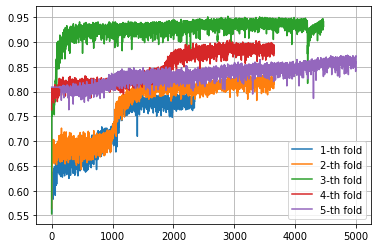

In [56]:
for i in range(len(accuracies_swish)):
    plt.plot(accuracies_swish[i], label=f"{i + 1}-th fold")
plt.grid()
plt.legend()

## Modelo Relu a prueba con K-Folds

In [57]:
data=df_B2B # se coloca el dataset de interés
variables=17

#Separando variables
X=data.iloc[:,0:variables].values #Variables
y=data.iloc[:,19:20].values #etiquetas
list_X=list(range(variables))

from time import time
t0 = time()

# Lista para almacenar los valores de AAE
accuracies_relu1 = []
accuracies_relu2 = []
accuracies_relu3 = []

# Lista para almacenar los errores durante el entrenamiento
accuracies_relu = []

# Se hace un K-Fold
kf = KFold()
k = 0
for train_index, test_index in kf.split(X):
    k += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #Estandarización de las variables de entrada
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test_kf = sc.transform(X_test)
    X_test_all = sc.transform(X)

    # Modelo con paradas por error
    # monitor = 'loss' y mode = 'min' para minimizar la pérdida
    callback = EarlyStopping(monitor='loss', patience=300, mode='min', restore_best_weights=True)
    # El modelo secuencial del TensorFlow
    model = Sequential()

    model.add(Dense(units=512, input_dim=len(list_X), activation='relu'))
    model.add(Dense(units=128, activation='tanh'))
    model.add(Dense(units=256, activation='sigmoid'))
    model.add(Dense(2, activation='softmax')) # 2 clases

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')

    history_2=model.fit(X_train, y_train, epochs=5000, batch_size=64, callbacks=[callback], verbose=0)
    print(len(history_2.history['loss']))
    accuracies_relu.append(history_2.history['accuracy'])
    
    # Prueba con vector de entrenamiento
    Train_predictions_2_1 = model.predict(X_train)
    Train_predictions_2_1 = np.argmax(Train_predictions_2_1, axis=-1).astype('int')
  
    # Prueba con vector de pruebas
    Train_predictions_2_2 = model.predict(X_test_kf)
    Train_predictions_2_2 = np.argmax(Train_predictions_2_2, axis=-1).astype('int')
  
    Train_predictions_2_3 = model.predict(X_test_all)
    Train_predictions_2_3 = np.argmax(Train_predictions_2_3, axis=-1).astype('int')
    
    acc = accuracy_score(y_train, Train_predictions_2_1)
    accuracies_relu1.append(acc)
    acc = accuracy_score(y_test, Train_predictions_2_2)
    accuracies_relu2.append(acc)
    acc = accuracy_score(y, Train_predictions_2_3)
    accuracies_relu3.append(acc)
    
print(f'Tiempo transcurrido: {(time() - t0)/60:.2f} minutos')

4329
3199
5000
3090
1862
Tiempo transcurrido: 13.62 minutos


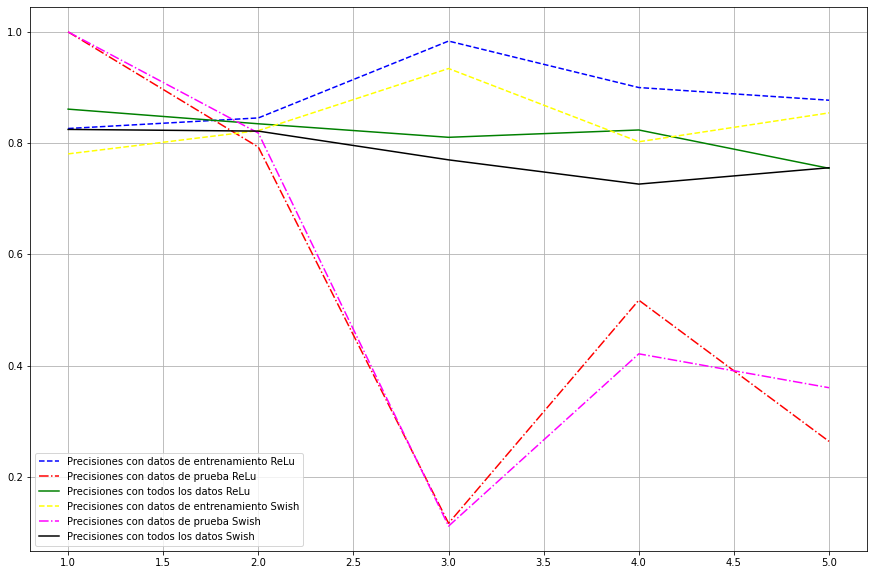

In [27]:
plt.figure(figsize=(15,10))
linestyles = ["dashed", "dashdot", "solid"]*2
colors = ["blue", "red", "green", "yellow", "magenta", "black"]
points = [accuracies_relu1, accuracies_relu2, accuracies_relu3,
          accuracies_swish1, accuracies_swish2, accuracies_swish3]
labels = ["Precisiones con datos de entrenamiento ReLu",
          "Precisiones con datos de prueba ReLu",
          "Precisiones con todos los datos ReLu",
          "Precisiones con datos de entrenamiento Swish",
          "Precisiones con datos de prueba Swish",
          "Precisiones con todos los datos Swish"]
for i in range(6):
    plt.plot(range(1, 6), points[i], linestyle=linestyles[i], color=colors[i], label=labels[i])
plt.grid(True)
plt.legend()

In [37]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 8.0 MB/s 
